In [141]:
import numpy as np
from matplotlib import pyplot as plt
eps = 0.001


class Function:
    def __init__(self, func, grad=None):
        self.func = func
        if grad:
            self.grad = grad
    
    def call(self, x, a, b):
        return self.func(x, a, b)
    
    def grad(self, x, a, b):
        if hasattr(self, "grad"):
            return self.grad(x, a, b)
        else:
            raise AttributeError("No gradient provided")
        

def mse_loss(y, params, func):
    x = np.linspace(eps, 1, 100)
    a, b = params
    mse = np.mean( (func(x, a, b) - y)**2 )
    
    return mse

def mse_grad(y, params, func):
    x = np.linspace(eps, 1, 100)
    a, b = params
    mse_grad = func.call(x, a, b) - y
    mse_grad = np.multiply(mse_grad,  func.grad(x, a, b))
    mse_grad = np.mean(mse_grad, axis=1)
    
    return mse_grad 

linear = Function( lambda x, a, b: a*x+b, lambda x, a, b: [x, [1]*len(x)] )
rational = Function( lambda x, a, b: a/(1+b*x), lambda x, a, b: [1/(1+b*x), -a*(1+b*x)**(-2)*x] )

mse_func = Function(mse_loss, mse_grad)

In [142]:
def generate_data(k=100):
    alpha, beta = np.random.uniform(size=(1, 2))[0]
    data = [alpha*x+beta + np.random.normal(0, 0.1) for x in np.linspace(0, 1, k)]
    
    return alpha, beta, data

real: (0.7439041326420089, 0.5844577893850348), guess: [0.6481214  0.27268746]
pred: [0.74929376 0.36147517], n_iter: 10000


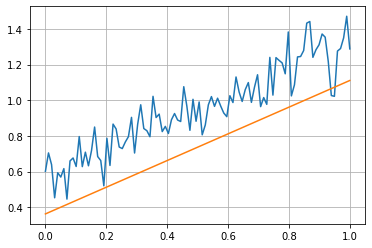

In [190]:
alpha, beta, y = generate_data()

n_iter = 0
max_iter = 10000
gamma = 0.0001

prev_pred = np.random.uniform(size=2)
print(f"real: {alpha, beta}, guess: {prev_pred}")
while n_iter < max_iter:
    
    pred = prev_pred - gamma*mse_func.grad(y, prev_pred, linear)*prev_pred
    n_iter += 1
    
    if min(abs(pred - prev_pred)) < eps:
        pass
    
    prev_pred = pred
    
print(f"pred: {pred}, n_iter: {n_iter}")

x = np.linspace(eps, 1, 100)
plt.plot(x, y)
plt.grid()
_ = plt.plot(x, linear.call(x, *pred))

real: (0.11443337373983342, 0.634570956685723), guess: [-0.2763133  -0.80517638]
pred: [-0.2763141  -0.80517787], n_iter: 1


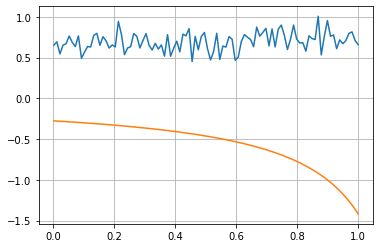

In [188]:
# alpha, beta, y = generate_data()

n_iter = 0
max_iter = 10000
gamma = 0.000001

# prev_pred = np.random.uniform(size=(1, 2))[0]
prev_pred = np.random.uniform(-1, 1, size=2)
print(f"real: {alpha, beta}, guess: {prev_pred}")
while n_iter < max_iter:
    
    pred = prev_pred - gamma*mse_func.grad(y, prev_pred, rational)*prev_pred
    n_iter += 1
    
    if min(abs(pred - prev_pred)) < eps:
        break
    
    prev_pred = pred
    
print(f"pred: {pred}, n_iter: {n_iter}")

x = np.linspace(eps, 1, 100)
plt.plot(x, y)
plt.grid()
_ = plt.plot(x, rational.call(x, *pred))

In [145]:
from lmfit import minimize as lm_min
from lmfit import Parameters

def mse_loss_lm(params, Y, X, func):
    a = params['a'].value
    b = params['b'].value
    # c = params['c'].value
    # d = params['d'].value
    # sum_ = 0
    #for x, y in zip(X, Y):
    mse = np.mean((func.call(X, a, b) - Y) ** 2)
    return mse

def linear_lm_call(x, a, b):
    #a = params['a'].value
    #b = params['b'].value

    return a*x+b

def linear_lm_grad(x, params):
    #a = params['a'].value
    #b = params['b'].value
    
    return [x, [1]*len(x)]
    
linear_lm = Function( linear_lm_call, linear_lm_grad )

param = Parameters()
rand_float = np.random.uniform
param.add('a', value=rand_float(), min=-100, max=100)
param.add('b', value=rand_float(), min=-100, max=100)

LM_res = lm_min(mse_loss_lm, param, args=(y, x, linear_lm), method="lm")
LM_koeffs = [LM_res.params["a"], LM_res.params["b"]]

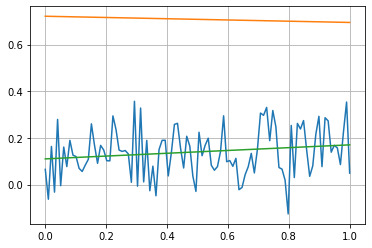

In [146]:
x = np.linspace(eps, 1, 100)
plt.plot(x, y)
plt.grid()
_ = plt.plot(x, linear.call(x, *pred))
_ = plt.plot(x, linear.call(x, *LM_koeffs))

In [164]:
phi = np.linspace(eps, 1, 100)
phi = np.vstack([phi, [1]*100])
theta = np.random.uniform(size=2)

In [194]:
p_theta = np.random.uniform(size=2)
i = 0
while i < max_iter:
    i+=1
    theta_pred = p_theta + 0.01 * phi.dot( y - phi.T.dot( p_theta ) ) 
    p_theta = theta_pred
    #if min(abs(theta_pred - p_theta)) < eps:
    #    break

In [195]:
LM_koeffs

[<Parameter 'a', value=0.060196716596294664, bounds=[-100:100]>,
 <Parameter 'b', value=0.10976948120500651, bounds=[-100:100]>]

In [196]:
p_theta

array([0.74893905, 0.57708612])

In [197]:
i

10000